# Fushion of IMU and Audio features
## Without doing time shifting
## Training on Synchronized Audio and IMU data

## IMU and Audio data is concatenated at an intermediate layer and then prediction is made

In [1]:
import numpy as np
import scipy.io

from keras import optimizers
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint


import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Activation
from keras.layers.core import Permute, Reshape
from keras import backend as K

from matplotlib import pyplot as plt
from PIL import Image as img_PIL


# random seed.
rand_seed = 2

from numpy.random import seed
seed(rand_seed)
from tensorflow import set_random_seed
set_random_seed(rand_seed)

Using TensorFlow backend.
/home/nesl/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nesl/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nesl/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nesl/anaconda3/envs/py36/l

In [2]:
def one_hot_encoding(y_data):
    Mapping=dict()
    sub_dirs=['downstair','upstair','run','jump','walk','handwashing','exercise']

    categories=10


    count=0
    for i in sub_dirs:
        Mapping[i]=count
        count=count+1

    y_features2=[]
    for i in range(len(y_data)):
        Type=y_data[i]
        lab=Mapping[Type]
        y_features2.append(lab)

    y_features=np.array(y_features2)
    y_features=y_features.reshape(y_features.shape[0],1)
    from keras.utils import to_categorical
    y_features = to_categorical(y_features)

    return y_features

In [3]:
path='data/'


def get_train_data(path=path):
    Train_data=np.load(path+'train_5000.npz')
    Features_imu=Train_data['arr_0']
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound

def get_valid_data(path=path):
    Train_data=np.load(path+'valid_1000.npz')
    Features_imu=Train_data['arr_0']
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound

def get_test_data(path=path):
    Train_data=np.load(path+'test_1377.npz')
    Features_imu=Train_data['arr_0']
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound


In [4]:
Features_imu,Labels,Features_sound = get_train_data()
print(Features_imu.shape, Labels.shape, Features_sound.shape)
print('Train Classes distribution: ',np.sum(Labels, axis =0))

Features_imu2,Labels2,Features_sound2 = get_valid_data()
print(Features_imu2.shape, Labels2.shape, Features_sound2.shape)
print('Valid Classes distribution: ',np.sum(Labels2, axis =0))

Features_imu3,Labels3,Features_sound3 = get_test_data()
print(Features_imu3.shape, Labels3.shape, Features_sound3.shape)
print('Test Classes distribution: ',np.sum(Labels3, axis =0))

(5000, 1, 40, 12) (5000, 7) (5000, 193)
Train Classes distribution:  [760. 994. 546. 780. 532. 732. 656.]
(1000, 1, 40, 12) (1000, 7) (1000, 193)
Valid Classes distribution:  [150. 188. 136. 141.  98. 157. 130.]
(1377, 1, 40, 12) (1377, 7) (1377, 193)
Test Classes distribution:  [219. 268. 124. 146. 143. 234. 243.]


In [5]:
model_path = 'data/Baseline_IMU_Audio_Fusion'

# Combined Model: Audio + IMU

In [6]:
rand_seed = 2

from numpy.random import seed
seed(rand_seed)
from tensorflow import set_random_seed
set_random_seed(rand_seed)

input_audio = keras.layers.Input(shape=(193,))
A1 = keras.layers.Dense(256, activation='relu')(input_audio)
A2 = keras.layers.Dense(256, activation='relu')(A1)
D1 = keras.layers.Dropout(0.3)(A2)
A5 = keras.layers.Dense(128, activation='relu')(D1)



num_feat_map=32
_, dim, win_len, _, = Features_imu.shape
input_imu = keras.layers.Input(shape=(dim, win_len, 12))

I1 = keras.layers.Conv2D(num_feat_map, kernel_size=(1, 5),
                 activation='relu',
                 padding='same')(input_imu)
I2=keras.layers.MaxPooling2D(pool_size=(1, 2))(I1)

I3 = keras.layers.Conv2D(num_feat_map, kernel_size=(1, 5),
                 activation='relu',
                 padding='same')(I2)
I4=keras.layers.MaxPooling2D(pool_size=(1, 2))(I3)
I5=keras.layers.Flatten()(I4)

I6= keras.layers.Dense(256, activation='relu')(I5)
D2 = keras.layers.Dropout(0.3)(I6)

I7= keras.layers.Dense(128, activation='relu')(D2)


# equivalent to added = keras.layers.add([x1, x2])
C1 =keras.layers.concatenate([A5, I7], axis=-1)


C3= keras.layers.Dense(64, activation='relu')(C1)

out = keras.layers.Dense(7, activation='softmax')(C3)

model = keras.models.Model(inputs=[input_audio, input_imu], outputs=out)


In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1, 40, 12)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, 40, 32)    1952        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 1, 20, 32)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1, 20, 32)    5152        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
input_1 (I

In [8]:



from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath=model_path, verbose=1,monitor='val_acc' ,save_best_only=True, save_weights_only=False)

In [9]:
Features_sound2.shape

(1000, 193)

In [10]:
batch_size = 128
epochs = 100
from keras import optimizers
from keras.optimizers import Adam

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= adam,
              metrics=['accuracy'])

import time
start_time = time.time()

learning_hist = model.fit([Features_sound,Features_imu], Labels,
                    verbose=1,
                    epochs=epochs,
                        shuffle=True,
                    batch_size=batch_size,
                        callbacks=[checkpointer],
                    validation_data=([Features_sound2,Features_imu2], Labels2)
                         
                         )

end_time = time.time()

print("---Time %s seconds ---" % (end_time - start_time))

Train on 5000 samples, validate on 1000 samples
Epoch 1/100
5000/5000 [==============================] - 33s 7ms/step - loss: 9.9775 - acc: 0.3168 - val_loss: 7.9915 - val_acc: 0.4750

Epoch 00001: val_acc improved from -inf to 0.47500, saving model to data/Baseline_IMU_Audio_Fusion
Epoch 2/100
5000/5000 [==============================] - 18s 4ms/step - loss: 7.2574 - acc: 0.5128 - val_loss: 6.6146 - val_acc: 0.5640

Epoch 00002: val_acc improved from 0.47500 to 0.56400, saving model to data/Baseline_IMU_Audio_Fusion
Epoch 3/100
5000/5000 [==============================] - 17s 3ms/step - loss: 3.8450 - acc: 0.6404 - val_loss: 1.0586 - val_acc: 0.8030

Epoch 00003: val_acc improved from 0.56400 to 0.80300, saving model to data/Baseline_IMU_Audio_Fusion
Epoch 4/100
5000/5000 [==============================] - 18s 4ms/step - loss: 0.7992 - acc: 0.8120 - val_loss: 0.4143 - val_acc: 0.8750

Epoch 00004: val_acc improved from 0.80300 to 0.87500, saving model to data/Baseline_IMU_Audio_Fusion

5000/5000 [==============================] - 11s 2ms/step - loss: 0.0350 - acc: 0.9872 - val_loss: 0.1432 - val_acc: 0.9610

Epoch 00041: val_acc did not improve from 0.97600
Epoch 42/100
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0361 - acc: 0.9874 - val_loss: 0.1226 - val_acc: 0.9680

Epoch 00042: val_acc did not improve from 0.97600
Epoch 43/100
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0202 - acc: 0.9942 - val_loss: 0.1276 - val_acc: 0.9720

Epoch 00043: val_acc did not improve from 0.97600
Epoch 44/100
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0169 - acc: 0.9934 - val_loss: 0.1366 - val_acc: 0.9730

Epoch 00044: val_acc did not improve from 0.97600
Epoch 45/100
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0223 - acc: 0.9936 - val_loss: 0.1459 - val_acc: 0.9680

Epoch 00045: val_acc did not improve from 0.97600
Epoch 46/100
5000/5000 [==============================] - 12s 2ms/step - 

5000/5000 [==============================] - 5s 915us/step - loss: 0.0217 - acc: 0.9920 - val_loss: 0.1030 - val_acc: 0.9770

Epoch 00084: val_acc did not improve from 0.98000
Epoch 85/100
5000/5000 [==============================] - 5s 915us/step - loss: 0.0373 - acc: 0.9910 - val_loss: 0.1293 - val_acc: 0.9730

Epoch 00085: val_acc did not improve from 0.98000
Epoch 86/100
5000/5000 [==============================] - 5s 942us/step - loss: 0.0229 - acc: 0.9932 - val_loss: 0.1221 - val_acc: 0.9780

Epoch 00086: val_acc did not improve from 0.98000
Epoch 87/100
5000/5000 [==============================] - 6s 1ms/step - loss: 0.0066 - acc: 0.9976 - val_loss: 0.1174 - val_acc: 0.9780

Epoch 00087: val_acc did not improve from 0.98000
Epoch 88/100
5000/5000 [==============================] - 8s 2ms/step - loss: 0.0077 - acc: 0.9968 - val_loss: 0.1659 - val_acc: 0.9740

Epoch 00088: val_acc did not improve from 0.98000
Epoch 89/100
5000/5000 [==============================] - 8s 2ms/step - 

# Accuracies

In [11]:
from keras.models import load_model

model = load_model(model_path)

In [12]:
#Train Accuracy
model.evaluate([Features_sound,Features_imu],Labels)

5000/5000 [==============================] - 8s 2ms/step


[0.0015213509622852143, 0.9998]

In [13]:
## Valid Accuracy
model.evaluate([Features_sound2,Features_imu2],Labels2)

1000/1000 [==============================] - 2s 2ms/step


[0.08836310338915064, 0.98]

In [14]:
## Test Accuracy
model.evaluate([Features_sound3,Features_imu3],Labels3)

1377/1377 [==============================] - 2s 2ms/step


[0.15336600019663232, 0.9607843137254902]

# Plotting

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


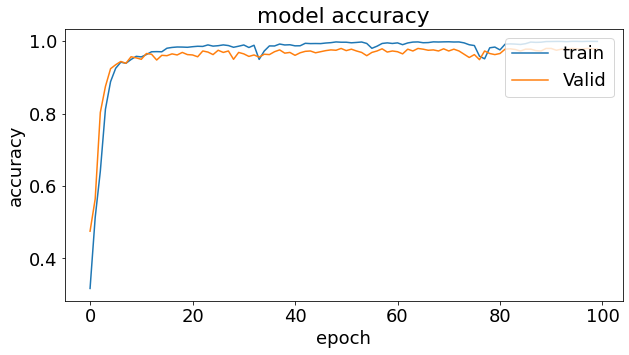

In [15]:
from matplotlib import pyplot as plt

print(learning_hist.history.keys())
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,5))

plt.plot(learning_hist.history['acc'])
plt.plot(learning_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()

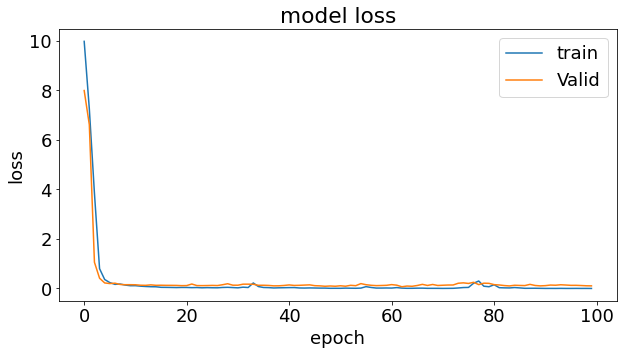

In [16]:
# summarize history for loss

from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 18})


plt.plot(learning_hist.history['loss'])
plt.plot(learning_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()